In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import sys
import os
path = '/content/drive/My Drive'
sys.path.append(path)
os.chdir(path)

In [ ]:
%pip install attrdict

In [ ]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from  torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from itertools import combinations
from attrdict import AttrDict

In [ ]:
def checkpoint(model,opts):
    with open('{}.pt'.format(opts.model),'wb') as f:
        torch.save(model,f)

In [ ]:
class myRnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,seq_len, dropout, bidirectional = False, type = 'lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len
        if type == 'lstm':
           self.rnn = nn.LSTM(input_size,hidden_size,num_layers,dropout = dropout, batch_first = True, bidirectional = bidirectional)
        elif type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        else:
          self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)



        if bidirectional:
            self.fc = nn.Linear(hidden_size*2,output_size)
        else:
            self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,X):   
        data  = X
        if self.bidirectional:
            output = self.rnn(data)[0]
            h_forward = output[:,-1,:self.hidden_size]
            h_backward = output[:,0,self.hidden_size:]
            output = torch.cat([h_forward,h_backward],dim = 1)
        else:
            output = self.rnn(data)[0][:,-1,:]
        output = self.fc(output)
        return output 

In [ ]:
class CoovidDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y 

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class CovidDataLoader(DataLoader):
    def __init__(self, X, y,batch_size):
        dataset = CoovidDataset(X,y)
        super().__init__(dataset,batch_size=batch_size, shuffle=True)

In [ ]:
def compute_loss(output, target, loss_fn):

    return loss_fn(output,target)

def train_loop_rnn(model,dataloader, optimizer,device,loss_fn):
    
    total_train_loss = 0
    total_train_seq = 0
    for X_train, y_train in dataloader:
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        optimizer.zero_grad()
        output =  model(X_train)
        loss = compute_loss(output,y_train,loss_fn)
        num_seq = output[0]
        total_train_loss += loss*num_seq
        total_train_seq += num_seq
        loss.backward()
        optimizer.step()
    return total_train_loss/total_train_seq   

def train_rnn(X_train, X_val, y_train, y_val,opts):
    loss_fn = nn.MSELoss().to(opts.device) #check device
    dataloader = CovidDataLoader(X_train,y_train,opts.batch_size)
    model = myRnn(opts.input_size,opts.hidden_size, opts.output_size, opts.num_layers,opts.seq_len, opts.dropout, opts.bidirectional,opts.type)

    if opts.device =='cuda':
        model.cuda()
    
    optimizer = optim.Adam(list(model.parameters()),lr=opts.lr)

    ##define val 
    X_val = torch.as_tensor(X_val).float().to(opts.device)
    y_val = torch.as_tensor(y_val).float().to(opts.device)


    mae_fn = nn.L1Loss().to(opts.device)

    best_val_loss = float('inf')
    early_stop =  0


    ##record  loss
    losses = {'epoch':[],'train':[],'test':[]}

    for epoch in range(opts.epochs):
        train_loss = train_loop_rnn(model,dataloader,optimizer,opts.device, loss_fn)
        output =  model(X_val)
        val_loss = compute_loss(output,y_val,loss_fn)

        if val_loss < best_val_loss:
            checkpoint(model,opts)
            best_val_loss = val_loss
            early_stop = 0
        else:
            early_stop += 1

        if early_stop > opts.early_stop:
            print('the validation loss has not improved for {} epochs'.format(opts.early_stop))
            print('best validation loss is {}'.format(best_val_loss))
            return losses 
        losses['epoch'].append(epoch)
        losses['train'].append(train_loss)
        losses['test'].append(val_loss)

        if epoch != 0  and val_loss > losses['test'][-2]:
            optimizer.param_groups[0]['lr'] *= opts.lr_decay
        if opts.print:
            print('epoch: {} | train_loss: {} | val_loss: {}'.format(epoch, train_loss,val_loss))
    return  losses  

In [ ]:
def plot_loss(losses):
    plt.figure(figsize=(20,8))
    plt.plot(losses['epoch'],losses['train'],color = '#F08080',label = "Train")
    plt.plot(losses['epoch'],losses['test'],color = "#DB7093",label = 'Validation')
    plt.xticks(losses['epoch'])
    plt.yscale('linear')
    plt.ylim(0,0.8)
    plt.title('Train and Validation Loss')
    plt.legend
    plt.show()

(7101, 40)
epoch: 0 | train_loss: tensor([0.7743], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.7298516035079956
epoch: 1 | train_loss: tensor([0.7169], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.6535018682479858
epoch: 2 | train_loss: tensor([0.5972], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.5377616286277771
epoch: 3 | train_loss: tensor([0.4508], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.38369327783584595
epoch: 4 | train_loss: tensor([0.2645], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.3065778911113739
epoch: 5 | train_loss: tensor([-1.7996], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.29370957612991333
epoch: 6 | train_loss: tensor([0.3876], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.2830103039741516
epoch: 7 | train_loss: tensor([0.9282], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.2727894186973572
epoch: 8 | train_loss: tensor([0.7572], device='cuda:0', grad_fn=<DivBackward0>) | val_los

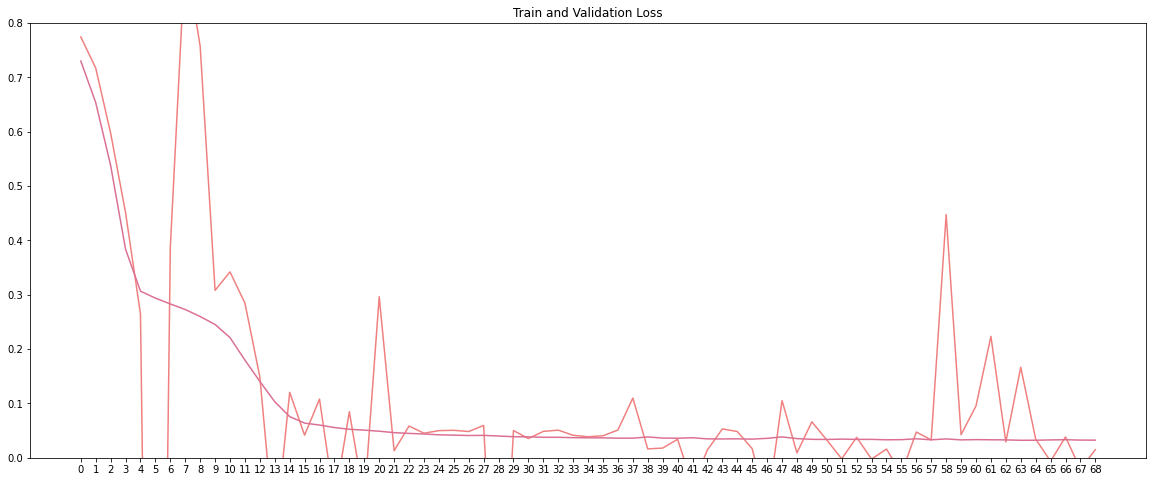

In [ ]:
opts = AttrDict()
args_dict = { 'model': 'rnn_standa',
              'type': 'lstm',
              'input_size': 10,
              'output_size': 1,
              'hidden_size': 16,
              'num_layers': 1, 
              'bidirectional': False,
              'dropout': 0.,
              'device': 'cuda',
              'epochs':100,
              'lr':1e-4,
              'lr_decay':0.999,
              'batch_size': 32,
              'early_stopping_patience': 5,
              'print': True,
              'early_stop':5,
              'seq_len': 10
             
}
opts.update(args_dict)
X = np.load('./final_data/feature_standa.npy')
y = np.load('./final_data/target_standa.npy')
print(X.shape)
X = X[:,:20]
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle = True,random_state=40)
opts.output_size = y_train.shape[1]
opts.seq_len = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
opts.input_size = X_train.shape[2]
losses = train_rnn(X_train, X_test, y_train, y_test,opts)
plot_loss(losses)

(7101, 40)
epoch: 0 | train_loss: tensor([0.0386], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.03434859216213226
epoch: 1 | train_loss: tensor([0.0368], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.032912418246269226
epoch: 2 | train_loss: tensor([0.0354], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.03124256618320942
epoch: 3 | train_loss: tensor([0.0328], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.02833407185971737
epoch: 4 | train_loss: tensor([0.0270], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.019037744030356407
epoch: 5 | train_loss: tensor([0.0138], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.010939325205981731
epoch: 6 | train_loss: tensor([0.0110], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.010233649052679539
epoch: 7 | train_loss: tensor([0.0102], device='cuda:0', grad_fn=<DivBackward0>) | val_loss: 0.009830058552324772
epoch: 8 | train_loss: tensor([0.0098], device='cuda:0', grad_fn=<DivBackward0>)

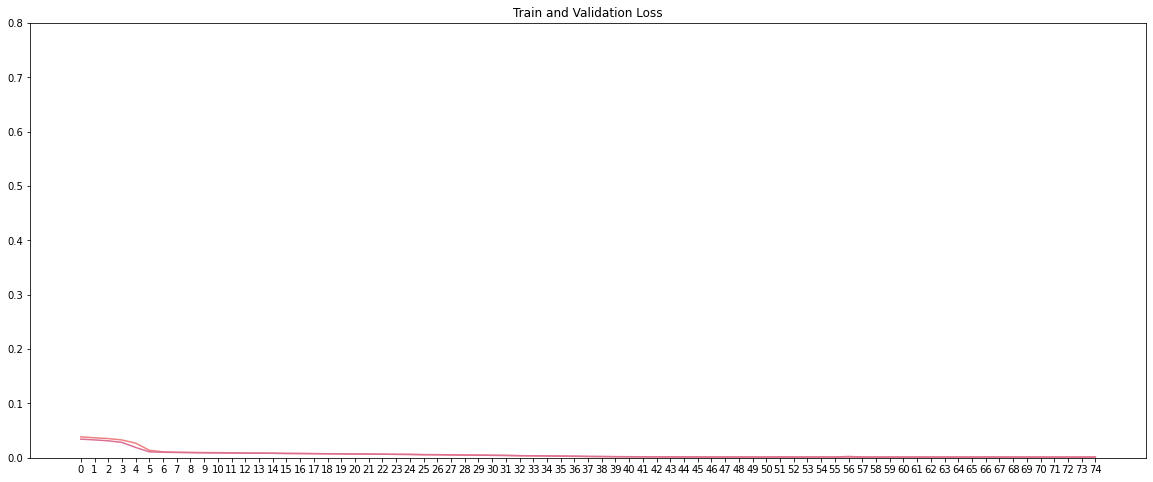

In [ ]:
opts = AttrDict()
args_dict = { 'model': 'rnn_minmax',
              'type': 'lstm',
              'input_size': 10,
              'output_size': 1,
              'hidden_size': 16,
              'num_layers': 1, 
              'bidirectional': False,
              'dropout': 0.,
              'device': 'cuda',
              'epochs':100,
              'lr':1e-4,
              'lr_decay':0.999,
              'batch_size': 32,
              'early_stopping_patience': 5,
              'print': True,
              'early_stop':5,
              'seq_len': 10
             
}
opts.update(args_dict)
X = np.load('./final_data/feature_minmax.npy')
y = np.load('./final_data/target_minmax.npy')
print(X.shape)
X = X[:,:20]
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle = True,random_state=40)
opts.output_size = y_train.shape[1]
opts.seq_len = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
opts.input_size = X_train.shape[2]
losses = train_rnn(X_train, X_test, y_train, y_test,opts)
plot_loss(losses)

In [ ]:
def compute_prediction(model,X_test):
  y_hat = model(X_test)
  return y_hat


2151
2151
[   0.           21.71717172   43.43434343   65.15151515   86.86868687
  108.58585859  130.3030303   152.02020202  173.73737374  195.45454545
  217.17171717  238.88888889  260.60606061  282.32323232  304.04040404
  325.75757576  347.47474747  369.19191919  390.90909091  412.62626263
  434.34343434  456.06060606  477.77777778  499.49494949  521.21212121
  542.92929293  564.64646465  586.36363636  608.08080808  629.7979798
  651.51515152  673.23232323  694.94949495  716.66666667  738.38383838
  760.1010101   781.81818182  803.53535354  825.25252525  846.96969697
  868.68686869  890.4040404   912.12121212  933.83838384  955.55555556
  977.27272727  998.98989899 1020.70707071 1042.42424242 1064.14141414
 1085.85858586 1107.57575758 1129.29292929 1151.01010101 1172.72727273
 1194.44444444 1216.16161616 1237.87878788 1259.5959596  1281.31313131
 1303.03030303 1324.74747475 1346.46464646 1368.18181818 1389.8989899
 1411.61616162 1433.33333333 1455.05050505 1476.76767677 1498.4848484

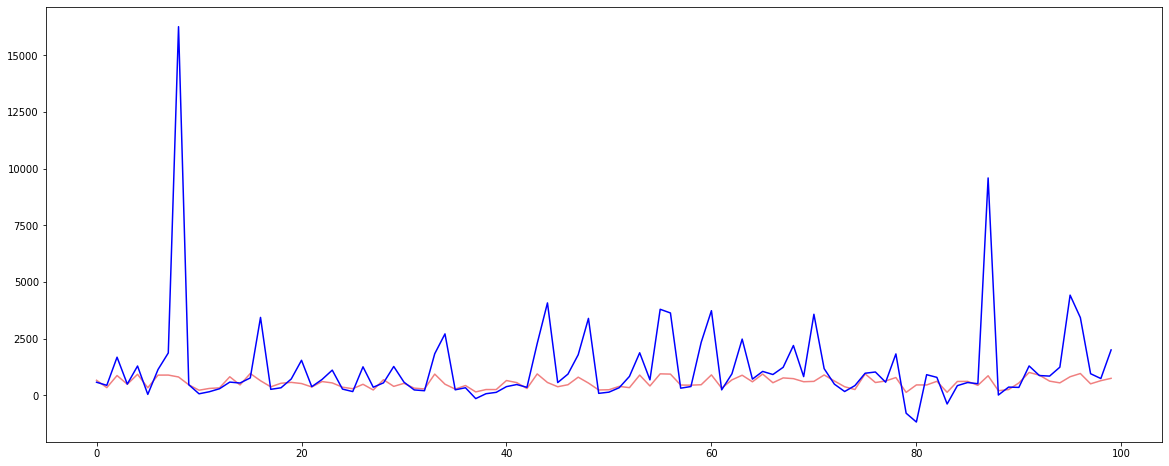

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
model = torch.load('{}.pt'.format('rnn'))
X_test = torch.as_tensor(X_test).float().to(opts.device)
y_test = torch.as_tensor(y_test).float().to(opts.device)

y_hat = compute_prediction(model,X_test)
y_test = y_test.cpu().numpy().flatten()
y_hat = y_hat.cpu().detach().numpy().flatten()

print(len(y_test))
print(len(y_hat))

days = range(len(y_hat))
daynew = np.linspace(0, len(days)-1, 100) 
print(daynew)
spl = make_interp_spline(days, y_test, k=3)
y_test_smooth = spl(daynew)
spl2 = make_interp_spline(days, y_hat, k=3)
y_hat_smooth = spl2(daynew)


plt.figure(figsize=(20,8))
plt.plot(y_hat_smooth,color = '#F08080',label = "prediction")
plt.plot(y_test_smooth,color = '#0000FF',label = "truth")
plt.show()



In [ ]:
def time_series_pred(model, last_day):

  predict = np.zeros([20,])
  for i in range(20):
    last_day = last_day.reshape(1,last_day.shape[0],1)
    last_day = torch.as_tensor(last_day).float().to(opts.device)
    y_hat = compute_prediction(model,last_day)
    y_hat = y_hat.cpu().detach().numpy().flatten()
    last_day = last_day.cpu().numpy().flatten()
    last_day = np.delete(last_day,0) 
    last_day = np.concatenate([last_day,y_hat])
    predict[i] = y_hat[0]
  return predict


df = pd.read_csv('./final_data/newest-cases-by-day.csv')
cases = df.loc[:,'CASE_COUNT']
cases = np.asarray(cases)
max = np.max(cases,axis = 0)

new_20 = cases[-20:]
print(new_20)

new_20 = new_20/max
model = torch.load('{}.pt'.format('rnn_minmax'))
predict = time_series_pred(model,new_20)
predict = predict*max
print(predict)



  



[1394  532 1160  950 1053 2308 1958 2152 2062 1871 1293 1381 2713 2780
 3018 2906 2935 1912 2265 4477]
[ 955.65349941 1018.66619833 1335.1746562  1484.58973393 1783.10158092
 2127.09852973 2000.84717217 2019.74074489 1958.29699236 1941.2657207
 2034.54759049 2445.37890476 2949.89252874 2948.50513607 2914.46440277
 2728.70291841 2531.94564471 2254.86912253 2381.14170066 2303.10248399]
